UCS Search:
Solution Path: [(0, 0), (0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 7), (3, 7), (3, 8), (4, 8), (5, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]
Total Count of Recharges: 9
Total Moves: 92
Final Battery Percentage: 80
Charging Point: (0, 0)


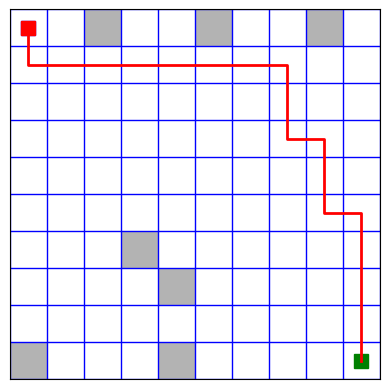

A* Search:
Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]
Total Count of Recharges: 8
Total Moves: 87
Final Battery Percentage: 30
Charging Point: (0, 0)


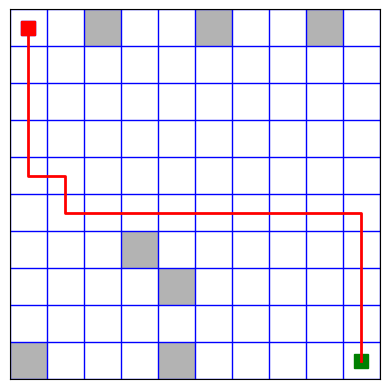

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.

    # Returns the possible actions from a given state.
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

class Robot:
    def __init__(self, env):
        self.env = env

    def recharge_battery(self):
        # Charging point is assumed to be the initial position
        return self.env.initial

    def search(self, algorithm):
        battery_level = 100
        recharge_count = 0
        move_count = 0
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}

        charging_point = None

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                solution_path = self.reconstruct_path(came_from, current_node.state)
                return solution_path, recharge_count, move_count, battery_level, charging_point

            move_count += 1
            battery_level -= 10
            if battery_level <= 0:
                charging_point = self.recharge_battery()
                battery_level = 100
                recharge_count += 1

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    if algorithm == 'UCS':
                        priority = new_cost
                    elif algorithm == 'A*':
                        priority = new_cost + heuristic(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return [], recharge_count, move_count, battery_level, charging_point

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

def visualize_grid_and_path(grid, path, charging_point):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
    ax.plot(charging_point[1], charging_point[0], 'rs', markersize=10)  # Charging point in red.
    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r-', linewidth=2)  # Plot the path in red.
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

# Generate a Random Grid Function
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

# Define the size of the grid and the probability of an obstacle in each cell
grid_size = 10
obstacle_probability = 0.1  # 10% chance of being an obstacle

# Generate a random grid
grid = generate_random_grid(grid_size, obstacle_probability)

# Define start and goal positions
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# Ensure start and goal are not obstacles
grid[start] = 0
grid[goal] = 0

# Create environment
environment = Environment(grid, start, goal)

# Create robot
robot = Robot(environment)

# Perform UCS search
solution_path_ucs, recharge_count_ucs, move_count_ucs, final_battery_ucs, charging_point_ucs = robot.search('UCS')
print("UCS Search:")
print("Solution Path:", solution_path_ucs)
print("Total Count of Recharges:", recharge_count_ucs)
print("Total Moves:", move_count_ucs)
print("Final Battery Percentage:", final_battery_ucs)
print("Charging Point:", charging_point_ucs)
visualize_grid_and_path(grid, solution_path_ucs, charging_point_ucs)

# Perform A* search
solution_path_astar, recharge_count_astar, move_count_astar, final_battery_astar, charging_point_astar = robot.search('A*')
print("A* Search:")
print("Solution Path:", solution_path_astar)
print("Total Count of Recharges:", recharge_count_astar)
print("Total Moves:", move_count_astar)
print("Final Battery Percentage:", final_battery_astar)
print("Charging Point:", charging_point_astar)
visualize_grid_and_path(grid, solution_path_astar, charging_point_astar)
